**Étapes pour utiliser le code :**

1. Préparez votre dataset comme décrit, avec les images dans un dossier et le fichier CSV des labels.

2. Mettez à jour les variables DATA_DIR, CSV_FILE, IMAGE_DIR, et surtout la liste EMOTION_LABELS pour qu'elle corresponde exactement à vos émotions et l'ordre de vos colonnes dans le CSV.

3. Exécutez le script.

4. Surveillez la console pour les métriques d'entraînement et de validation. Ajustez les hyperparamètres (BATCH_SIZE, NUM_EPOCHS, LEARNING_RATE, FREEZE_FEATURES) si nécessaire en fonction des performances observées.

**Organisation des données :**

your_dataset/

├── images/

│   ├── image_001.jpg

│   ├── image_002.jpg

│   └── ...

└── labels.csv # Ou un autre format de fichier, contenant les chemins d'images et leurs étiquettes

**Format du dataset :**

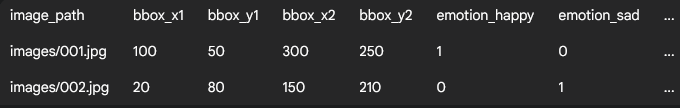

In [1]:
# pip install torch torchvision torchaudio
# pip install matplotlib scikit-learn pandas tqdm

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models#, transforms
import torchvision.transforms.v2 as transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
import os
import time
import copy
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, mean_squared_error
import numpy as np
from tqdm import tqdm # Pour les barres de progression

#import matplotlib.pyplot as plt

On a le choix de fine tuner la dernière couche OU tout le modele (pas le même temps)

# I/ Configuration et Hyperparamètres 

In [3]:
# --- 0. Configuration et Hyperparamètres ---
DATA_DIR = r'C:\Users\alber\Desktop\visual_studio_code\dossier_jedha\Jedha_Full_stack\00_Final_Project\emotic' # Chemin vers votre dossier racine du dataset
CSV_FILE = os.path.join(DATA_DIR, 'labels.csv') # Chemin vers votre fichier CSV d'étiquettes
IMAGE_DIR = os.path.join(DATA_DIR, 'images') # Chemin vers le dossier contenant les images

BODY_BBOX_COLS = ['body_bbox_x1', 'body_bbox_y1', 'body_bbox_x2', 'body_bbox_y2'] # Noms de vos colonnes de face_box dans le CSV

# Définissez vos émotions binaires ici, dans le même ordre que vos colonnes dans le CSV
EMOTION_LABELS = [
    'Disconnection',
    'Doubt/Confusion',
    'Fatigue',
    'Pain',
    'Disquietment',
    'Annoyance',
    'others',
    'adhd_emotion'
]

NUM_CLASSES = len(EMOTION_LABELS)

# Définissez vos labels continus (DAV) ici
CONTINUOUS_LABELS = ['arousal', 'valence','dominance']
NUM_CONTINUOUS_CLASSES = len(CONTINUOUS_LABELS) # Sera 3
IMAGE_DIM_COLS = ['height', 'width'] # Si vous utilisez ces colonnes pour le prétraitement

BATCH_SIZE = 64 #32
NUM_EPOCHS = 2 #20
LEARNING_RATE = 0.002 #0.001
FREEZE_FEATURES = True # True pour ne fine-tuner que la dernière couche, False pour fine-tuner tout le modèle

# Pondération des pertes : Vous pouvez ajuster ces valeurs si une tâche est plus importante que l'autre
LOSS_WEIGHT_EMOTIONS = 1.0
LOSS_WEIGHT_CONTINUOUS = 1.0

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Utilisation du périphérique : {DEVICE}")

Utilisation du périphérique : cuda:0


In [4]:
# print(DATA_DIR)
# print(CSV_FILE)
# print(IMAGE_DIR)

# II/ Création du Dataset PyTorch personnalisé (modifié)

In [5]:
# --- 1. Création du Dataset PyTorch personnalisé (modifié) ---
class EmotionDataset(Dataset):
    def __init__(self, df, img_dir, emotion_cols, continuous_cols, bbox_cols, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.emotion_cols = emotion_cols
        self.continuous_cols = continuous_cols
        self.bbox_cols = bbox_cols # Nouvelle ligne pour les colonnes de la bbox

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['image'])

        emotion_labels = row[self.emotion_cols].values.astype(float)
        emotion_labels = torch.tensor(emotion_labels, dtype=torch.float32)
        continuous_labels = row[self.continuous_cols].values.astype(float)
        continuous_labels = torch.tensor(continuous_labels, dtype=torch.float32)

        image = Image.open(img_path)
        x1, y1, x2, y2 = row[self.bbox_cols].values.astype(int)
        cropped_image = image.crop((x1, y1, x2, y2))
        
        if self.transform:
            image = self.transform(cropped_image)

        return image, emotion_labels, continuous_labels

# III/ Transformations d'images

In [6]:
# --- 2. Transformations d'images ---
# Transformations pour l'entraînement (augmentation des données)
data_transforms = {
    'train': transforms.Compose([
        transforms.RGB(),
        transforms.RandomResizedCrop(224), # Recadrage aléatoire et redimensionnement à 224x224
        transforms.RandomHorizontalFlip(), # Retournement horizontal aléatoire
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Jitter de couleur
        transforms.ToTensor(), # Convertir en Tensor PyTorch (met les pixels entre 0 et 1)
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalisation (moyenne et std ImageNet)
    ]),
    # Transformations pour la validation/test (juste redimensionnement et normalisation)
    'val': transforms.Compose([
        transforms.RGB(),
        transforms.Resize(256), # Redimensionner le plus petit côté à 256
        transforms.CenterCrop(224), # Centre Crop à 224x224
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

c:\Users\alber\anaconda3\envs\dl_project_py311\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


# IV/ Chargement des données et division Train/Val 

In [7]:
# --- 3. Chargement des données et division Train/Val ---
print("Chargement des données...")
full_df = pd.read_csv(CSV_FILE)

# Division du dataset en ensembles d'entraînement et de validation
train_df, val_df = train_test_split(full_df, test_size=0.2, random_state=42, stratify=full_df['adhd_emotion'] if True else None) # Stratify si possible

train_dataset = EmotionDataset(df=train_df, img_dir=IMAGE_DIR, emotion_cols=EMOTION_LABELS, continuous_cols=CONTINUOUS_LABELS, bbox_cols=BODY_BBOX_COLS, transform=data_transforms['train'])
val_dataset = EmotionDataset(df=val_df, img_dir=IMAGE_DIR, emotion_cols=EMOTION_LABELS, continuous_cols=CONTINUOUS_LABELS, bbox_cols=BODY_BBOX_COLS, transform=data_transforms['val'])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count() // 2 or 1) # Utilisez des workers si > 1 CPU
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count() // 2 or 1)

dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

print(f"Taille du dataset d'entraînement : {dataset_sizes['train']}")
print(f"Taille du dataset de validation : {dataset_sizes['val']}")

Chargement des données...
Taille du dataset d'entraînement : 13516
Taille du dataset de validation : 3380


In [8]:
# for i in range (10):
#     print(train_dataset[i][0])

# V/ Chargement du modèle ResNet18 pré-entraîné

In [ ]:
# --- 4. Chargement du modèle ResNet18 pré-entraîné ---
print("Chargement et modification du modèle ResNet18 pré-entraîné...")

class MultiTaskResNet(nn.Module):
    def __init__(self, num_emotion_classes, num_continuous_classes):
        super(MultiTaskResNet, self).__init__()
        # Charger ResNet18 pré-entraîné
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

        for param in self.resnet.parameters():
            param.requires_grad = False

        # Obtenir le nombre de caractéristiques de la couche fc avant qu'elle ne soit remplacée
        num_ftrs = self.resnet.fc.in_features

        # Supprimer la dernière couche fc par défaut
        self.resnet.fc = nn.Identity() # Remplace fc par une couche d'identité pour obtenir les features avant la classification

        # Tête de classification pour les émotions (multi-label)
        self.emotion_head = nn.Sequential(
            nn.Linear(num_ftrs, 512), # Couche cachée optionnelle
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_emotion_classes) # Sortie pour les émotions
        )

        # Tête de régression pour dominance, arousal, valence
        self.continuous_head = nn.Sequential(
            nn.Linear(num_ftrs, 512), # Couche cachée optionnelle
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_continuous_classes) # Sortie pour DAV
        )

    def forward(self, x):
        features = self.resnet(x) # Passer l'image à travers ResNet pour obtenir les caractéristiques
        emotion_output = self.emotion_head(features) # Passer les caractéristiques à la tête des émotions
        continuous_output = self.continuous_head(features) # Passer les caractéristiques à la tête DAV
        return emotion_output, continuous_output

model_ft = MultiTaskResNet(NUM_CLASSES, NUM_CONTINUOUS_CLASSES)
model_ft = model_ft.to(DEVICE)

Chargement et modification du modèle ResNet18 pré-entraîné...


In [10]:
# from torchinfo import summary

# # Print model summary
# summary(model_ft)  # (batch_size, input_features)

# VI/ Fonction de perte et Optimiseur

In [11]:
# --- 5. Fonction de perte et Optimiseur ---
# Pour la classification multi-label, Binary Cross-Entropy with Logits Loss est la norme.
# Elle combine une couche Sigmoid et la Binary Cross-Entropy.
# Perte pour la classification multi-label des émotions
criterion_emotions = nn.BCEWithLogitsLoss()
# Perte pour la régression des valeurs continues (DAV)
criterion_continuous = nn.MSELoss() # Mean Squared Error Loss est standard pour la régression

# Seulement les paramètres qui nécessitent des gradients seront optimisés
optimizer_ft = optim.Adam(model_ft.parameters(), lr=LEARNING_RATE)

# Ordonnanceur de taux d'apprentissage (réduit le LR après un certain nombre d'époques)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# VII/ Fonction d'entraînement et d'évaluation

In [12]:
# --- 6. Fonction d'entraînement et d'évaluation ---
def train_model(model, criterion_emotions, criterion_continuous, optimizer, loss_w_emotion, loss_w_continious, epochs=2):
    since = time.time()

    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

    for epoch in range(epochs):
        print(f'Epoch {epoch}/{epochs - 1}')
        print('-' * 10)

        model.train()
        total_loss = 0.0
        total_loss_emotions = 0.0
        total_loss_continuous = 0.0
        correct = 0
        correct_emotions = 0
        correct_continuous = 0

        for inputs, emotion_labels, continuous_labels in train_loader:
            optimizer.zero_grad()
            emotion_outputs, continuous_outputs = model(inputs)
            loss_emotions = criterion_emotions(emotion_outputs, emotion_labels)
            loss_continuous = criterion_continuous(continuous_outputs, continuous_labels)

            # Perte totale avec pondération
            loss = loss_w_emotion * loss_emotions + loss_w_continious * loss_continuous
            loss.backward()
            optimizer.step()

            # Statistiques
            total_loss += loss.item() * inputs.size(0)
            total_loss_emotions += loss_emotions.item() * inputs.size(0)
            total_loss_continuous += loss_continuous.item() * inputs.size(0)
            correct_emotions += (torch.argmax(emotion_outputs, dim=1) == emotion_labels).sum().item()  # Count correct predictions
            correct_continuous += (torch.argmax(continuous_outputs, dim=1) == continuous_labels).sum().item()  # Count correct predictions
            correct += correct_emotions + correct_continuous

            # Pour les émotions : convertir les logits en prédictions binaires
            # emotion_probs = torch.sigmoid(emotion_outputs)
            # emotion_preds = (emotion_probs > 0.5).float() # Seuil de 0.5

        train_loss = total_loss / len(train_loader)
        train_loss_emotions = total_loss_emotions / len(train_loader)
        train_loss_continuous = total_loss_continuous / len(train_loader)
        train_acc = correct/len(train_loader)
        train_emotion_acc = correct_continuous/len(train_loader)
        train_continuous_acc = correct_continuous/len(train_loader)

           
        # Sauvegarder le meilleur modèle basé sur le F1-Micro des émotions ou un score combiné
        # Pour une tâche multi-objectifs, il faut décider quelle métrique est la plus importante.
        # Ici, on priorise le F1-Micro des émotions.
        model.eval()

        val_loss = 0.0
        val_loss_emotions = 0.0
        val_loss_continuous = 0.0
        val_correct = 0
        val_correct_emotions = 0
        val_correct_continuous = 0

        with torch.no_grad():  # No need to compute gradients during validation
            for inputs, emotion_labels, continuous_labels in val_loader:
                emotion_outputs, continuous_outputs = model(inputs)
                val_loss_emotions = criterion_emotions(emotion_outputs, emotion_labels)
                val_loss_continuous = criterion_continuous(continuous_outputs, continuous_labels)
                val_loss = loss_w_emotion * val_loss_emotions + loss_w_continious * val_loss_continuous
                val_loss += val_loss.item() * inputs.size(0)
                val_loss_emotions += val_loss_emotions.item() * inputs.size(0)
                val_loss_continuous += val_loss_continuous.item() * inputs.size(0)
                val_correct_emotions += (torch.argmax(emotion_outputs, dim=1) == emotion_labels).sum().item()  # Count correct predictions
                val_correct_continuous += (torch.argmax(continuous_outputs, dim=1) == continuous_labels).sum().item()  # Count correct predictions
                val_correct += val_correct_emotions + val_correct_continuous

        val_loss = val_loss / len(val_loader)
        val_loss_emotions = val_loss_emotions / len(val_loader)
        val_loss_continuous = val_loss_continuous / len(val_loader)
        val_acc = val_correct/len(val_loader)
        val_emotion_acc = val_correct_continuous/len(val_loader)
        val_continuous_acc = val_correct_continuous/len(val_loader)

        # Store metrics in history dictionary
        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    time_elapsed = time.time() - since
    print(f'Entraînement complet en {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    return history


In [ ]:
history = train_model(model_ft, 
                      criterion_emotions, 
                      criterion_continuous, 
                      optimizer=optimizer_ft, 
                      loss_w_emotion=LOSS_WEIGHT_EMOTIONS, 
                      loss_w_continious=LOSS_WEIGHT_CONTINUOUS, 
                      epochs=2)


Epoch 0/1
----------


In [ ]:
# for inputs, emotion_labels, continuous_labels in dataloaders['train']:
#     inputs = inputs.to(DEVICE)
#     emotion_labels = emotion_labels.to(DEVICE)
#     continuous_labels = continuous_labels.to(DEVICE)
#     print(inputs.shape)
#     break

In [ ]:
# test_image = torch.rand(64, 3, 224, 224).to('cuda')
# model_ft = model_ft.to('cuda')
# result = model_ft(test_image)

In [ ]:
# result[0].shape

# VIII/ Lancement de l'entraînement 

In [ ]:
# --- 7. Lancement de l'entraînement ---
print("\nDébut de l'entraînement...")
model_ft = train_model(model_ft, criterion_emotions, criterion_continuous, optimizer_ft, exp_lr_scheduler, num_epochs=NUM_EPOCHS)

In [ ]:
# --- 8. Sauvegarde du modèle entraîné ---
# Créez un dossier pour les modèles si n'existe pas
os.makedirs('saved_models', exist_ok=True)
model_save_path = os.path.join('saved_models', 'resnet18_emotion_dav_multi_person.pth')
torch.save(model_ft.state_dict(), model_save_path)
print(f"Modèle sauvegardé à : {model_save_path}")

In [ ]:
# --- 9. (Optionnel) Évaluation finale sur l'ensemble de validation ---
# Charger le modèle pour l'évaluation
# model_ft.eval() # Mettre en mode évaluation
# ... Vous pouvez réutiliser le code d'évaluation de la fonction train_model ici si vous voulez une évaluation finale séparée.

print("\n--- Entraînement terminé ---")